<a href="https://colab.research.google.com/github/MTxSouza/Spam-Detector/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jackksoncsie/spam-email-dataset
!unzip spam-email-dataset.zip -d dataset
!rm -rf spam-email-dataset.zip

  0% 0.00/2.86M [00:00<?, ?B/s]
100% 2.86M/2.86M [00:00<00:00, 61.2MB/s]
Archive:  spam-email-dataset.zip
  inflating: dataset/emails.csv      


# Notebook setup

### Installations

In [4]:
!apt-get install python3-enchant

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common enchant-2 hunspell-en-us libaspell15
  libenchant-2-2 libhunspell-1.7-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-2-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common enchant-2 hunspell-en-us libaspell15
  libenchant-2-2 libhunspell-1.7-0 libtext-iconv-perl python3-enchant
0 upgraded, 10 newly installed, 0 to remove and 18 not upgraded.
Need to get 1,464 kB of archives.
After this operation, 5,673 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtext-iconv-perl amd64 1.7-7build3 [14.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libaspell15 amd64 0.60.8-4build1 [325 kB]
Get:3 http://archive.ubuntu.

### Imports

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import stopwords
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import enchant
import string
import nltk
import time
import gc

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
my_stopwords = set(
    stopwords.words('english') + \
    list(string.punctuation) +\
    # all characters and words below
    # was selected after some analysis
    [
        'w'
    ]
)
word_checker = enchant.Dict('en_US')
under_sampler = RandomUnderSampler()

### Utils

In [48]:
def remove_word_space(text: str) -> str:
    '''
    Removes blank spaces of words. For
    example:

    - in: 'spam  detector    dataset  '
    - out: 'spam detector dataset'
    '''
    new_text = []
    for word in text.split(' '):
        word = word.strip()
        if len(word) > 1:
            new_text.append(word)
    return ' '.join(new_text).strip()

def word_frequency(column: pd.Series) -> Counter:
    frequency = []
    for word_list in column.str.split(' '): frequency += word_list
    counter = Counter(frequency)
    # sorting counter
    return dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

def remove_stopwords(text: str) -> str:
    new_text = []
    for word in text.split(' '):
        if word in my_stopwords:
            continue
        new_text.append(word)
    return ' '.join(new_text)

def text_correction(text: str) -> str:
    new_text = []
    for word in text.split(' '):
        check = word_checker.check(word)
        if check:
            new_text.append(word)
            continue
        suggestions = word_checker.suggest(word)
        if suggestions:
            suggestions = suggestions[0].lower()
            if suggestions == 'w':
                suggestions = word
            new_text.append(suggestions)
    return ' '.join(new_text).lower()

# Analysis

In [9]:
df = pd.read_csv('/content/dataset/emails.csv')

BALANCE = True
if BALANCE:
    x, y = df['text'].values.reshape(-1,1), df['spam'].values
    ux, uy = under_sampler.fit_resample(x, y)
    df = pd.DataFrame(data={'text': ux.reshape(-1), 'spam': uy})
    del x, y, ux, uy
    gc.collect()

In [10]:
df.head()

,text,spam
0,"Subject: re : real options vince , thanks ag...",0
1,"Subject: visit to enron grant and vince , th...",0
2,Subject: re : tony hamilton tony has already ...,0
3,Subject: re : var let ' s meet at 4 : 00 . v...,0
4,Subject: wharton fap 2001 webcafe access abou...,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2736 non-null   object
 1   spam    2736 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.9+ KB


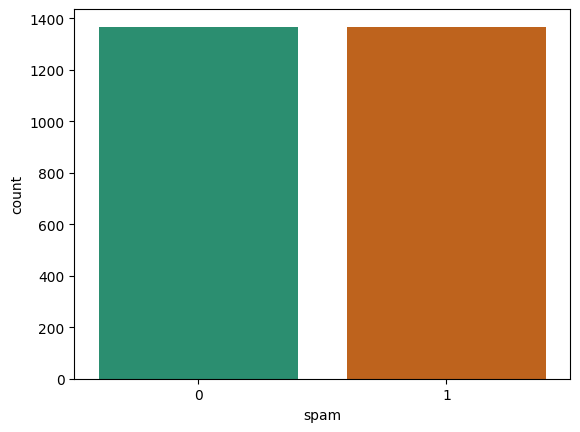

In [12]:
# Checking distribution of classes
sns.countplot(data=df, x='spam', palette='Dark2')
plt.show()

In [13]:
# Converting all text to lower case
df['text_lower_case'] = df['text'].str.lower()

In [14]:
# Removing 'subject:' string from text
df['text_no_prefix'] = df['text_lower_case'].str.removeprefix('subject:')

In [15]:
# Removing unnecessary spaces between
# words
df['text_space_adjusted'] = df['text_no_prefix'].map(remove_word_space)

In [16]:
# Removing stopwords of text
df['text_cleaned'] = df['text_space_adjusted'].map(remove_stopwords)
final_text_column = 'text_cleaned'

In [17]:
# Applying spelling correction
# *it takes ~6min to finish | BALANCE = False
# *it takes ~3min to finish | BALANCE = True
TEXT_CORRECTION = True

if TEXT_CORRECTION:
    text_cottection_init_timer = time.time()
    df['text_fixed'] = df['text_cleaned'].map(text_correction)
    final_text_column = 'text_fixed'
    text_cottection_out_timer = (time.time() - text_cottection_init_timer) / 60
    print(f'Execution time: {text_cottection_out_timer:.2f} min')
    del text_cottection_init_timer, text_cottection_out_timer
    gc.collect()

Execution time: 1.07 min


In [18]:
# Saving length of texts
df['text_length'] = df[final_text_column].str.split(' ').map(len)

In [19]:
df.head()

,text,spam,text_lower_case,text_no_prefix,text_space_adjusted,text_cleaned,text_fixed,text_length
0,"Subject: re : real options vince , thanks ag...",0,"subject: re : real options vince , thanks ag...","re : real options vince , thanks again for ...",re real options vince thanks again for coming ...,real options vince thanks coming austin speak ...,real options vince thanks coming austin speak ...,40
1,"Subject: visit to enron grant and vince , th...",0,"subject: visit to enron grant and vince , th...","visit to enron grant and vince , thanks for...",visit to enron grant and vince thanks for arra...,visit enron grant vince thanks arranging visit...,visit enron grant vince thanks arranging visit...,64
2,Subject: re : tony hamilton tony has already ...,0,subject: re : tony hamilton tony has already ...,re : tony hamilton tony has already done thi...,re tony hamilton tony has already done this de...,tony hamilton tony already done desleigh langf...,tony hamilton tony already done sleigh dangerf...,312
3,Subject: re : var let ' s meet at 4 : 00 . v...,0,subject: re : var let ' s meet at 4 : 00 . v...,re : var let ' s meet at 4 : 00 . vince j k...,re var let meet at 00 vince kaminski 06 01 200...,var let meet 00 vince kaminski 06 01 2000 09 1...,var let meet 00 vince minsk 06 01 2000 09 19 j...,161
4,Subject: wharton fap 2001 webcafe access abou...,0,subject: wharton fap 2001 webcafe access abou...,wharton fap 2001 webcafe access about a mont...,wharton fap 2001 webcafe access about month ag...,wharton fap 2001 webcafe access month ago rece...,wharton flap 2001 web cafe access month ago re...,57


In [20]:
# Counting frequency of words for each
# class
df_spam = df[df['spam'] == 1].copy()
df_no_spam = df[df['spam'] == 0].copy()

In [21]:
frequency_of_word_spam = word_frequency(df_spam[final_text_column])
frequency_of_word_no_spam = word_frequency(df_no_spam[final_text_column])

In [22]:
# Filtering top words
top_filter = 50
top_frequency_of_word_spam = {word: freq for _, (word, freq) in zip(range(50), frequency_of_word_spam.items())}
top_frequency_of_word_no_spam = {word: freq for _, (word, freq) in zip(range(50), frequency_of_word_no_spam.items())}

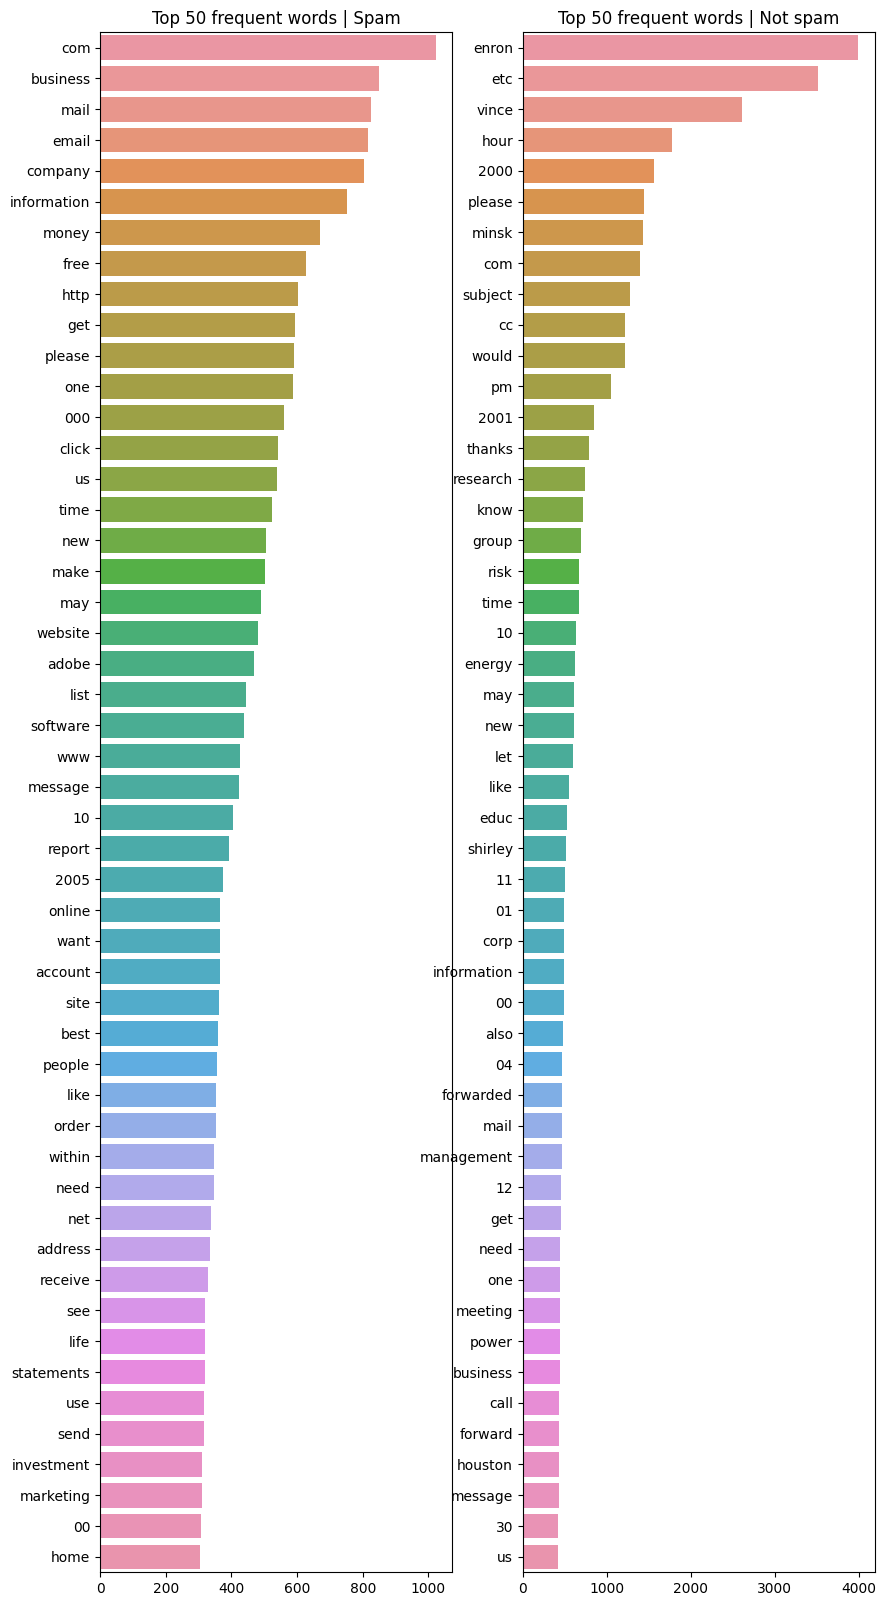

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10,20))

ax[0].set_title(label=f'Top {top_filter} frequent words | Spam')
sns.barplot(x=list(top_frequency_of_word_spam.values()), y=list(top_frequency_of_word_spam.keys()), ax=ax[0])

ax[1].set_title(label=f'Top {top_filter} frequent words | Not spam')
sns.barplot(x=list(top_frequency_of_word_no_spam.values()), y=list(top_frequency_of_word_no_spam.keys()), ax=ax[1])

plt.show()

In [24]:
# Finding similar words and comparing
# its frequencies
similar_words = {}
for target_word in set(list(frequency_of_word_spam.keys()) + list(frequency_of_word_no_spam.keys())):
    if target_word in frequency_of_word_spam and target_word in frequency_of_word_no_spam:
        similar_words[target_word] = [frequency_of_word_spam[target_word], frequency_of_word_no_spam[target_word]]
similar_words = dict(sorted(similar_words.items(), key=lambda x: max(x[1]), reverse=True))

In [25]:
target_words = np.asarray(a=list(similar_words.keys()))
frequencies = np.asarray(a=list(similar_words.values())).reshape(-1,2)

In [26]:
top_words = 50
top_target_words = target_words[:top_words]
top_frequencies = frequencies[:top_words]

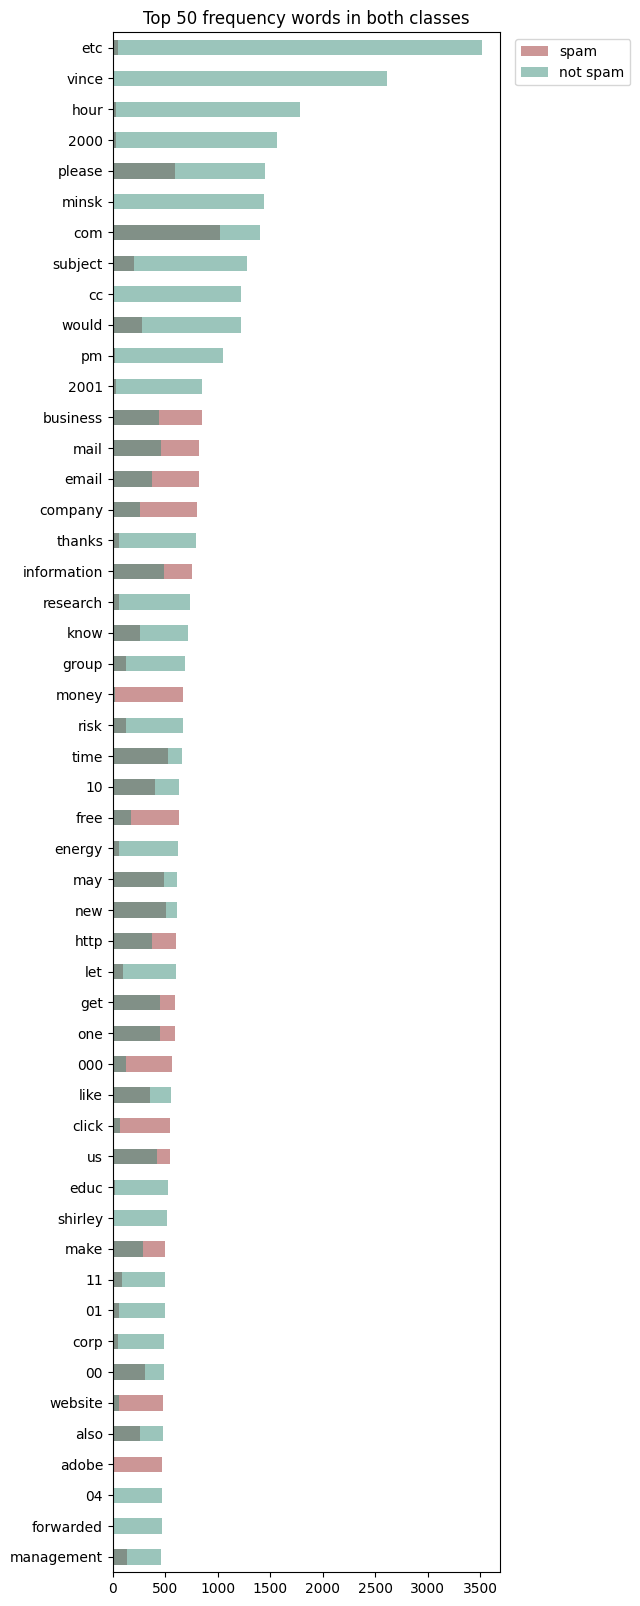

In [27]:
fig = plt.figure(figsize=(5,20))

ax = sns.barplot(x=top_frequencies[:,0], y=top_target_words, label='spam', color='#AC1D1D', width=0.5)
sns.barplot(x=top_frequencies[:,1], y=top_target_words, label='not spam', color='#2A9A81', width=0.5, ax=ax)

for bar1, bar2 in zip(ax.containers[0], ax.containers[1]):
    bar1.set_alpha(0.5)
    bar2.set_alpha(0.5)

plt.title(label=f'Top {top_words} frequency words in both classes')
plt.legend(loc='upper left', bbox_to_anchor=(1.02,1))
plt.show()
# --------------------------------------------
# There are some words that are more frequent
# in one class than other, and there is no
# word with a high frequency and same number
# ocorrence in both classes, it is good to
# differ if a text is a spam or not

In [28]:
# Checking length of texts of
# each class
len_text_spam = dict(df_spam['text_length'].value_counts())
len_text_no_spam = dict(df_no_spam['text_length'].value_counts())

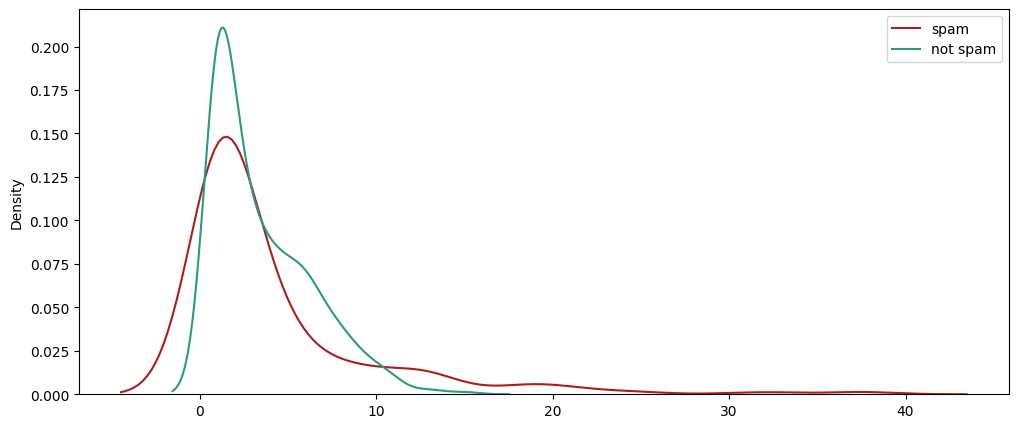

In [29]:
fig = plt.figure(figsize=(12,5))

ax = sns.kdeplot(data=len_text_spam, color='#AC1D1D', label='spam')
sns.kdeplot(data=len_text_no_spam, color='#2A9A81', label='not spam', ax=ax)

plt.legend()
plt.show()
# --------------------------------------------
# It seems that spam messages has a more
# distribuited text lengths than not spam
# messages, maybe it can help a model to classify
# if a text is either a spam or not.

In [31]:
# Creating word dictionary of
# texts
word_dict = {}
for text in df[final_text_column]:
    for word in text.split(' '):
        if word not in word_dict:
            word_dict[word] = len(word_dict)

In [32]:
print(f'Number of unique words: {len(word_dict)}')

Number of unique words: 22416


# Model

Multinomial Naive Bayes:

$P(C_n|X_i) = {P(X_i|C_n)*P(C_n) \over P(X_i|C_n)*P(C_n) + P(X_i|C_n')*P(C_n')} = {P(word|spam)*P(spam) \over P(word|spam)*P(spam) + P(word|notSpam)*P(notSpam)}$

In [49]:
# Creating Multinomial Naive
# Bayes model
model = MultinomialNB()

In [51]:
vectorizer = CountVectorizer()

In [56]:
# Splitting data into train
# and validation
y = df['spam'].values
x_vec = vectorizer.fit_transform(df[final_text_column])

xtrain, xvalid, ytrain, yvalid = train_test_split(x_vec, y, train_size=0.8, random_state=1234, shuffle=True)

In [57]:
print(f'Train:\n\t{xtrain.shape}\n\t{ytrain.shape}')
print(f'Valid:\n\t{xvalid.shape}\n\t{yvalid.shape}')

Train:
	(2188, 22215)
	(2188,)
Valid:
	(548, 22215)
	(548,)


In [58]:
# Running training
results = model.fit(xtrain, ytrain)

In [60]:
# Running predictions
ypred = model.predict(xvalid)

In [84]:
# Computing confusion matrix
cm = confusion_matrix(yvalid, ypred, labels=[0, 1])
accuracy = accuracy_score(yvalid, ypred)

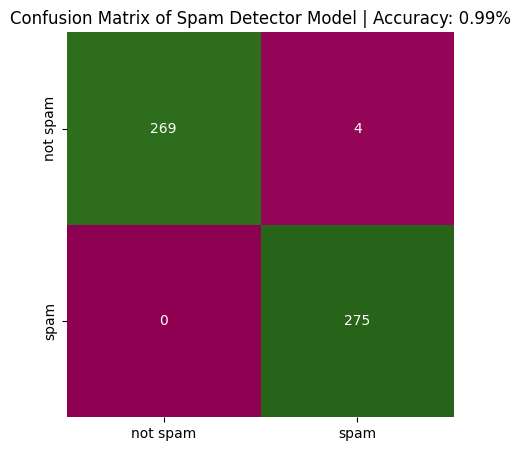

In [86]:
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(data=cm, annot=True, fmt='.0f', cmap='PiYG', cbar=False)
ax.set_title(label=f'Confusion Matrix of Spam Detector Model | Accuracy: {accuracy:.2f}%')
ax.set_xticklabels(['not spam', 'spam'])
ax.set_yticklabels(['not spam', 'spam'])
plt.show()